In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import iqr


df = pd.read_csv("ges.csv")
df.head()

,Unnamed: 0,UID No,GSDB No,Manufacturer,Engine Identification,Combustor Description,Eng Type,B/P Ratio,Pressure Ratio,Rated Thrust (kN),...,Final Test Date,Compliance with fuel venting requirements,Remark 1,Remark 2,Remark 3,Remark 4,Remark 5,Remark 6,Remark 7,Remark 8
0,0,1AS001,1,Allied Signal,TFE731-2-2B,NaN,TF,2.64,13.90,15.60,...,1976-04-01,NaN,Not required to meet GASEOUS regulations,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1AS002,1,Allied Signal,TFE731-3,NaN,TF,2.64,14.30,16.50,...,1976-08-01,NaN,Not required to meet GASEOUS regulations,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,4AL003,4,Rolls-Royce Corporation,AE3007A,NaN,MTF,5.23,18.08,33.73,...,1995-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,6AL004,6,Rolls-Royce Corporation,AE3007C1,NaN,MTF,5.10,16.60,31.50,...,1995-04-19,NaN,Results based on Rolls Royce report EDR 15171B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,6AL005,6,Rolls-Royce Corporation,AE3007A1,Type 1,MTF,4.77,17.97,34.91,...,1995-04-19,NaN,For effectivity see Rolls-Royce Notice to Oper...,Results are based on Rolls-Royce report EDR 15...,AE3007A1 data in this report replace data repo...,NaN,NaN,NaN,NaN,NaN


In [2]:
df2 = df[['Eng Type' , 'B/P Ratio', 'Fuel LTO Cycle (kg)  ' ,'HC LTO Total mass (g)', 'CO LTO Total Mass (g)', 'NOx LTO Total mass (g)']].copy()
df2.tail()

,Eng Type,B/P Ratio,Fuel LTO Cycle (kg),HC LTO Total mass (g),CO LTO Total Mass (g),NOx LTO Total mass (g)
810,TF,5.1,151.0,337.0,2803.0,1086.0
811,TF,5.0,NaN,NaN,NaN,NaN
812,TF,5.0,265.0,NaN,NaN,NaN
813,TF,4.9,260.0,NaN,NaN,NaN
814,TF,4.9,274.0,NaN,NaN,NaN


In [3]:
df2.isna().sum()

Eng Type                  0
B/P Ratio                 8
Fuel LTO Cycle (kg)       1
HC LTO Total mass (g)     9
CO LTO Total Mass (g)     8
NOx LTO Total mass (g)    9
dtype: int64

In [4]:
df2.rename(columns={"Fuel LTO Cycle (kg)  ":"Fuel LTO Cycle (kg)"}, inplace=True)

In [5]:
df2 = df2.dropna()

In [6]:
df2.isna().sum()

Eng Type                  0
B/P Ratio                 0
Fuel LTO Cycle (kg)       0
HC LTO Total mass (g)     0
CO LTO Total Mass (g)     0
NOx LTO Total mass (g)    0
dtype: int64

In [7]:
# Step1: Finding the IQR

Q1c = df2['CO LTO Total Mass (g)'].quantile(0.25)
Q3c = df2['CO LTO Total Mass (g)'].quantile(0.75)
IQR = Q3c - Q1c


# Step2: Finding the upper and lower limits

lower_limit = Q1c - 1.5 * IQR
upper_limit = Q3c + 1.5 * IQR

# Step3: Print the lower and upper limits
print('Lower Limit:', lower_limit)
print('Upper Limit:', upper_limit)

# Step4: outliers
outliers = df2[(df2['CO LTO Total Mass (g)'] < lower_limit) | (df2['CO LTO Total Mass (g)'] > upper_limit)]


# Step5: Trimming the outliers
co_df = df2[(df2['CO LTO Total Mass (g)'] > lower_limit) & (df2['CO LTO Total Mass (g)'] < upper_limit)]
co_df.shape



Lower Limit: -3109.0
Upper Limit: 12779.0


(715, 6)

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Convert the categorical column to numerical values using label encoding
le = LabelEncoder()
df2['Eng Type'] = le.fit_transform(df2['Eng Type'])

# Split the dataset into features (X) and targets (y)
X = df2.drop(['HC LTO Total mass (g)', 'CO LTO Total Mass (g)', 'NOx LTO Total mass (g)'], axis=1)
y_HC = df2['HC LTO Total mass (g)']
y_CO = df2['CO LTO Total Mass (g)']
y_NOx = df2['NOx LTO Total mass (g)']

# Split the data into training and testing sets
X_train, X_test, y_train_HC, y_test_HC, y_train_CO, y_test_CO, y_train_NOx, y_test_NOx = train_test_split(X, y_HC, y_CO, y_NOx, test_size=0.2, random_state=42)

# Create pipelines to scale the data and fit the Random Forest models for each target variable
model_HC = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
model_CO = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
model_NOx = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))

# Train the Random Forest regression models
model_HC.fit(X_train, y_train_HC)
model_CO.fit(X_train, y_train_CO)
model_NOx.fit(X_train, y_train_NOx)

# Predict the emissions for new data
new_data = pd.DataFrame({'B/P Ratio': [4.77], 'Fuel LTO Cycle (kg)': [157], 'Eng Type': [0]})
new_data['Eng Type'] = le.transform(new_data['Eng Type'])
emissions_HC = model_HC.predict(new_data)
emissions_CO = model_CO.predict(new_data)
emissions_NOx = model_NOx.predict(new_data)

# Print the predicted emissions
print("Predicted emissions:")
print(f"Hydrocarbons: {emissions_HC[0]} g")
print(f"Carbon monoxide: {emissions_CO[0]} g")
print(f"Oxides of nitrogen: {emissions_NOx[0]} g")

# Evaluate the models on the test set
y_pred_HC = model_HC.predict(X_test)
score_HC = r2_score(y_test_HC, y_pred_HC)
mse_HC = mean_squared_error(y_test_HC, y_pred_HC)
rmse_HC = np.sqrt(mse_HC)

y_pred_CO = model_CO.predict(X_test)
score_CO = r2_score(y_test_CO, y_pred_CO)
mse_CO = mean_squared_error(y_test_CO, y_pred_CO)
rmse_CO = np.sqrt(mse_CO)

y_pred_NOx = model_NOx.predict(X_test)
score_NOx = r2_score(y_test_NOx, y_pred_NOx)
mse_NOx = mean_squared_error(y_test_NOx, y_pred_NOx)
rmse_NOx = np.sqrt(mse_NOx)

print("R-Squared, MSE, and RMSE scores:")
print(f"Hydrocarbons: R-Squared={score_HC:.4f}, MSE={mse_HC:.4f},RMSE={rmse_HC:.4f}")
print(f"Carbon monoxide: R-Squared={score_CO:.4f}, MSE={mse_CO:.4f}, RMSE={rmse_CO:.4f}")
print(f"Oxides of nitrogen: R-Squared={score_NOx:.4f}, MSE={mse_NOx:.4f}, RMSE={rmse_NOx:.4f}")

c:\Users\bhakt\anaconda3\envs\name_of_my_env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
c:\Users\bhakt\anaconda3\envs\name_of_my_env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
c:\Users\bhakt\anaconda3\envs\name_of_my_env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Predicted emissions:
Hydrocarbons: 237.77764397046306 g
Carbon monoxide: 3960.3838650450703 g
Oxides of nitrogen: 10227.45 g
R-Squared, MSE, and RMSE scores:
Hydrocarbons: R-Squared=0.2654, MSE=8878061.2155,RMSE=2979.6076
Carbon monoxide: R-Squared=0.4250, MSE=23583317.1012, RMSE=4856.2658
Oxides of nitrogen: R-Squared=0.9734, MSE=1714552.4273, RMSE=1309.4092


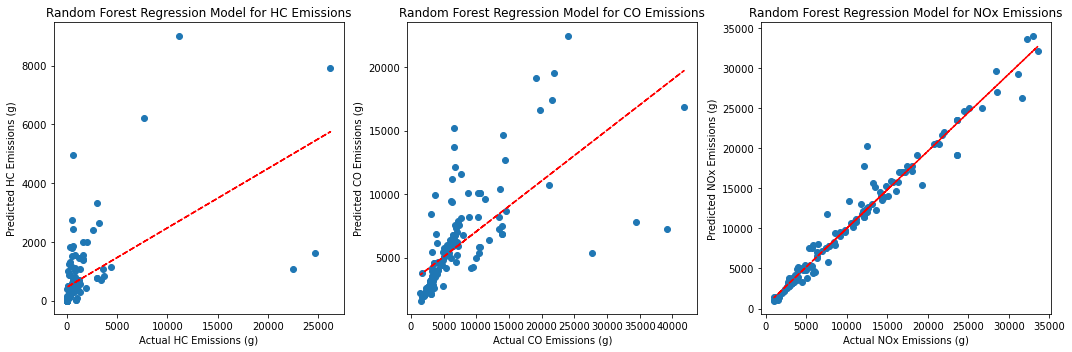

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the predicted vs actual values for Hydrocarbons
axes[0].scatter(y_test_HC, y_pred_HC)
axes[0].set_xlabel("Actual HC Emissions (g)")
axes[0].set_ylabel("Predicted HC Emissions (g)")
axes[0].set_title("Random Forest Regression Model for HC Emissions")
z = np.polyfit(y_test_HC, y_pred_HC, 1)
p = np.poly1d(z)
axes[0].plot(y_test_HC, p(y_test_HC), "r--")

# Plot the predicted vs actual values for Carbon Monoxide
axes[1].scatter(y_test_CO, y_pred_CO)
axes[1].set_xlabel("Actual CO Emissions (g)")
axes[1].set_ylabel("Predicted CO Emissions (g)")
axes[1].set_title("Random Forest Regression Model for CO Emissions")
z = np.polyfit(y_test_CO, y_pred_CO, 1)
p = np.poly1d(z)
axes[1].plot(y_test_CO, p(y_test_CO), "r--")

# Plot the predicted vs actual values for Oxides of Nitrogen
axes[2].scatter(y_test_NOx, y_pred_NOx)
axes[2].set_xlabel("Actual NOx Emissions (g)")
axes[2].set_ylabel("Predicted NOx Emissions (g)")
axes[2].set_title("Random Forest Regression Model for NOx Emissions")
z = np.polyfit(y_test_NOx, y_pred_NOx, 1)
p = np.poly1d(z)
axes[2].plot(y_test_NOx, p(y_test_NOx), "r--")

plt.tight_layout()
plt.show()
